# The Canada/US Border Crossing Dataset


*Exploration of whether the variance in border crossings since 1972 is related to socio-economic indices*

## Load Data

**Import Libraries**

In [1]:
import pandas as pd #working with dataframes

**Load Data**

In [2]:
# Data accessed from: https://open.canada.ca/data/en/dataset/6e438d59-880a-4f5e-827d-6c35243cf10a
# Data accessed on: 2019-05-24

border_df_000 = pd.read_csv('24100002.csv')

C:\DataScience\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Dataset Versions**

* 000 - raw dataset
* 001 - reduce column 'Length of stay' to a single class 'Length of stay, total'
* 002 - remove columns with 1 or less unique elements/classes
* 003 - remove 'Windsor Tunnel' as 75% of entries are NaN
* 004 - remove DGUID column (NaNs); replace with Region column based on GEO
* 005 - (004) reduce 'Mode of transportation' to a single class 'Total'; remove 'Total' from 'Trip characteristics'
* 006 - (004) Remove 'Total' class for 'Mode of transportation' and 'Trip characteristics'
* 007 - (004) Select 'Trucks' class from 2004 to 2018

## Data Structure

In [37]:
border_df_005.head()

,REF_DATE,GEO,Trip characteristics,VECTOR,COORDINATE,VALUE,Region
1,1972-01,Canada,Total United States vehicles entering,v129300,1.2.1.1,616944.0,Canada
8,1972-01,Canada,Total Canadian vehicles returning,v129307,1.3.1.1,810082.0,Canada
16,1972-01,Nova Scotia,Total United States vehicles entering,v129315,2.2.1.1,164.0,Nova Scotia
23,1972-01,Nova Scotia,Total Canadian vehicles returning,v129322,2.3.1.1,129.0,Nova Scotia
31,1972-01,New Brunswick,Total United States vehicles entering,v129330,4.2.1.1,94865.0,New Brunswick


In [38]:
border_df_005.shape

(101910, 7)

### What are the number of NaNs for each column?

In [39]:
border_df_005.isna().sum()

REF_DATE                0
GEO                     0
Trip characteristics    0
VECTOR                  0
COORDINATE              0
VALUE                   0
Region                  0
dtype: int64

*Several features are almost completely NaNs. 0.5% of the target (i.e., 'Value') are NaNs*

### What are the number of unique elements for each column?

In [40]:
border_df_005.nunique()

REF_DATE                  567
GEO                       141
Trip characteristics        2
VECTOR                    282
COORDINATE                564
VALUE                   31706
Region                     10
dtype: int64

*Any feature that has 1 or less unique elements can be removed, since there is no variance to explore*

## Data Munging

**Reduce 'Length of Stay' to a single class 'Total'**

In [7]:
# For this study we are not interested in the 'Length of stay'
border_df_001 = border_df_000[border_df_000['Length of stay'] == 'Length of stay, total']
print(border_df_000.shape)
print(border_df_001.shape)

(769590, 17)
(461754, 17)


*This reduced the number of rows by 40%*

**Drop columns that have 1 or less unique elements**

In [8]:
drop_nonunique = [] # create an empty list to put columns to be dropped in
column_unique = border_df_001.nunique() # shows the number of unique elements in each feature

for i in range(len(border_df_001.nunique())):
    if column_unique[i] <= 1: # if the number of unique elements in each feature is <= 1
        drop_nonunique.append(column_unique.index[i]) # add that column to the list

drop_nonunique    

['Length of stay',
 'UOM',
 'UOM_ID',
 'SCALAR_FACTOR',
 'SCALAR_ID',
 'STATUS',
 'SYMBOL',
 'TERMINATED',
 'DECIMALS']

In [9]:
border_df_002 = border_df_001.drop(drop_nonunique, axis = 1)
print(border_df_000.shape)
print(border_df_002.shape)

(769590, 17)
(461754, 8)


*This reduced the number of columns by 53%*

**Remove Border Crossing with NaNs for VALUE**

In [10]:
# select only those entries with NaNs for VALUE
border_df_002_NaN = border_df_002[border_df_002['VALUE'].isna()]
print(border_df_002_NaN.shape)

# display unique values of GEO with NaNs for VALUE
border_df_002_NaN['GEO'].unique() # Windsor Tunnel, Ontario contains NaNs for VALUE

(2376, 8)


array(['Windsor Tunnel, Ontario'], dtype=object)

In [11]:
# Lets look at how many Windsor Tunnel entries there are
WindsorTunnel_000 = border_df_000[border_df_000['GEO'] == 'Windsor Tunnel, Ontario']
print(WindsorTunnel_000.shape)

# How many Windsor Tunnel entries are NaN
WindsorTunnel_000_NaN = WindsorTunnel_000[WindsorTunnel_000['VALUE'].isna()]
print(WindsorTunnel_000_NaN.shape)

(5265, 17)
(3960, 17)


*Roughly 75% of Windsor Tunnel entries are NaN. Closer inspection shows that it is likely that the Windsor Tunnel closed and this is the result of the NaNs.*

In [12]:
# Lets drop Windsor Tunnel from the dataset
border_df_003 = border_df_002[border_df_002['GEO'] != 'Windsor Tunnel, Ontario']

**Create a Region Column Based on GEO. Remove DGUID**

In [13]:
#Create a list of all border crossing sites
GEO_list = border_df_003['GEO'].unique().tolist()

#Create an empty dictionary to populate
Region_key = {}

# For each site listed in 'GEO' associate the province
# For cities, split on the comma and add the province
# For provinces, just duplicate the value
for i in GEO_list:
    comma_position = i.find(',')
    if comma_position != -1:
        region_split = i.split(',')
        region_value = region_split[1].strip()
    else:
        region_value = i
        
    Region_key[i] = region_value

# Drop DGUID column
border_df_004 = border_df_003.drop('DGUID', axis = 1)

# Add a column for Region
border_df_004['Region'] = border_df_004['GEO'].map(Region_key)
border_df_004.head()

,REF_DATE,GEO,Trip characteristics,Mode of transportation,VECTOR,COORDINATE,VALUE,Region
0,1972-01,Canada,Total vehicles entering Canada,"Mode of transportation, total",v129299,1.1.1.1,1427026.0,Canada
1,1972-01,Canada,Total United States vehicles entering,"Mode of transportation, total",v129300,1.2.1.1,616944.0,Canada
2,1972-01,Canada,Total United States vehicles entering,Automobiles,v129301,1.2.1.2,557108.0,Canada
3,1972-01,Canada,Total United States vehicles entering,Trucks,v129305,1.2.1.3,59491.0,Canada
4,1972-01,Canada,Total United States vehicles entering,Other vehicles,v129306,1.2.1.4,345.0,Canada


**Reduce 'Mode of transportation' to a single class 'Total'**

In [14]:
# Reduce 'Mode of transportation' to a single class
border_df_005 = border_df_004[border_df_004['Mode of transportation'] == 'Mode of transportation, total']
border_df_005 = border_df_005.drop(['Mode of transportation'], axis = 1)

# Remove total for 'Trip characteristics'
border_df_005 = border_df_005[border_df_005['Trip characteristics'] != 'Total vehicles entering Canada']
print(border_df_000.shape)
print(border_df_005.shape)

(769590, 17)
(101910, 7)


**Remove 'Total' class for 'Mode of transportation' and 'Trip characteristics'**

In [15]:
# Reduce 'Mode of transportation' to a single class
border_df_006 = border_df_004[border_df_004['Mode of transportation'] != 'Mode of transportation, total']

# Remove total for 'Trip characteristics'
border_df_006 = border_df_006[border_df_006['Trip characteristics'] != 'Total vehicles entering Canada']
print(border_df_000.shape)
print(border_df_006.shape)

(769590, 17)
(305730, 8)


**Select 'Trucks', 'Total' by 'REF_DATE'**

In [16]:
# Select only 'Trucks' class from 'Mode of transportation', and, 'Canada' class from 'GEO'
border_df_007 = border_df_004[(border_df_004['Mode of transportation'] == 'Trucks') & (border_df_004['GEO'] == 'Canada')]

# Split REF_DATE into 'Year' and 'Month'
border_df_007[['Year','Month']] = border_df_007['REF_DATE'].str.split('-',expand=True)

# Filter dataframe so only dates between 2004 and 2018
border_df_007 = border_df_007[(border_df_007['Year'] >= '2004') & (border_df_007['Year'] <= '2017')]
border_df_007.groupby(['Year'])['VALUE'].sum().values

C:\DataScience\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


array([6724141., 6666355., 6467388., 6285421., 5771734., 4885733.,
       5258507., 5270026., 5389779., 5371491., 5359891., 5279674.,
       5449768., 5513243.])

## Data Exploration

### Look at the distribution of crossings by Province

Lets create a barchart comparing the number of crossings for Canada and each Province/Territory and subdivide by citizenship

In [17]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\DataScience\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


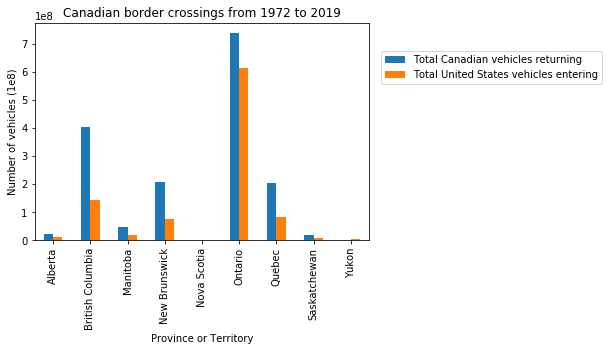

In [18]:
# Bar chart of crossings by Province/Territory

# Let's remove the total Canadian crossings for every year
border_df_005_noCan = border_df_005[border_df_004['Region'] != 'Canada']

# source code for .unstack() : https://stackoverflow.com/questions/48238305/bar-plot-with-groupby
# we group the data by Province/Territory and then by citizenship and return the sum of value
border_df_005_noCan.groupby(['Region','Trip characteristics'])['VALUE'].sum().unstack().plot(kind = 'bar')

plt.title('Canadian border crossings from 1972 to 2019')
plt.ylabel('Number of vehicles (1e8)')
plt.xlabel('Province or Territory')

plt.legend(bbox_to_anchor=(1.45, 0.8),
           bbox_transform=plt.gcf().transFigure)

*Ontario has had 2x more crossings than any other province or territory. Unlike the others, the number of US vehicles crossing is much closer to the number of Canadian vehicles returning. The Yukon is the only region to have a greater number of US vehicles entering than Canadian vehicles returning.*

### Let's add info about the mode of transportation

In [29]:
# Import Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Let's remove the total Canadian crossings for every year
border_df_006_noCan = border_df_006[border_df_006['Region'] != 'Canada']

**Create arrays to populate the bar chart**

In [33]:
# USA
usa = border_df_006_noCan[border_df_006_noCan['Trip characteristics'] == 'Total United States vehicles entering']

# USA automobiles
usa_autos = usa[usa['Mode of transportation'] == 'Automobiles']
usa_autos_sum = usa_autos.groupby(['Region'])['VALUE'].sum().values
#usa_autos_sum

# USA trucks
usa_trucks = usa[usa['Mode of transportation'] == 'Trucks']
usa_trucks_sum = usa_trucks.groupby(['Region'])['VALUE'].sum().values
#usa_trucks_sum

# USA other vehicles
usa_other = usa[usa['Mode of transportation'] == 'Other vehicles']
usa_other_sum = usa_other.groupby(['Region'])['VALUE'].sum().values
#usa_other_sum

# Canada 
can = border_df_006_noCan[border_df_006_noCan['Trip characteristics'] == 'Total Canadian vehicles returning']

# Canada automobiles
can_autos = can[can['Mode of transportation'] == 'Automobiles']
can_autos_sum = can_autos.groupby(['Region'])['VALUE'].sum().values
#can_autos_sum

# Canada trucks
can_trucks = can[can['Mode of transportation'] == 'Trucks']
can_trucks_sum = can_trucks.groupby(['Region'])['VALUE'].sum().values
#can_trucks_sum

# Canada other vehicles
can_other = can[can['Mode of transportation'] == 'Other vehicles']
can_other_sum = can_other.groupby(['Region'])['VALUE'].sum().values
#can_other_sum

**Create headers for x-labels**

In [34]:
#regions = border_df_006_noCan['Region'].unique().tolist()
regions = ['Alberta',
           'British Columbia',
           'Manitoba',
           'New Brunswick',
           'Nova Scotia',
           'Ontario',
           'Quebec',
           'Saskatchewan',
           'Yukon']

**Create the Plot**

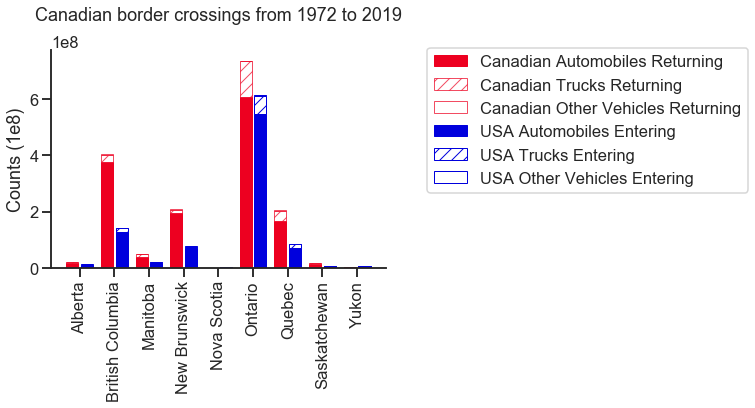

In [35]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 0.35
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(can_autos_sum))
    neg_bar_positions = pos_bar_positions + bar_width + (epsilon*5)

    # make bar plots
    can_autos_bar = plt.bar(pos_bar_positions, can_autos_sum, bar_width,
                              color='#ED0020',
                            edgecolor='#ED0020',
                            linewidth = line_width,                            
                              label='Canadian Automobiles Returning')
    can_trucks_bar = plt.bar(pos_bar_positions, can_trucks_sum, bar_width,
                              bottom=can_autos_sum,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='Canadian Trucks Returning')
    can_other_bar = plt.bar(pos_bar_positions, can_other_sum, bar_width,
                               bottom=can_trucks_sum+can_autos_sum,
                               alpha=opacity,
                               color='white',
                               edgecolor='#ED0020',
                               linewidth=line_width,
                               hatch='0',
                               label='Canadian Other Vehicles Returning')
    usa_autos_bar = plt.bar(neg_bar_positions, usa_autos_sum, bar_width,
                              color='#0000DD',
                            edgecolor='#0000DD',
                              #ecolor="#0000DD",
                              linewidth=line_width,
                              label='USA Automobiles Entering')
    usa_trucks_bar = plt.bar(neg_bar_positions, usa_trucks_sum, bar_width,
                              bottom=usa_autos_sum,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='USA Trucks Entering')
    usa_other_bar = plt.bar(neg_bar_positions, usa_other_sum, bar_width,
                               bottom=usa_trucks_sum+usa_autos_sum,
                               color="white",
                               hatch='0',
                               edgecolor='#0000DD',
                               ecolor="#0000DD",
                               linewidth=line_width,
                               label='USA Other Vehicles Entering')
    plt.xticks((neg_bar_positions+pos_bar_positions)/2, regions
               ,rotation=90
              )
    plt.ylabel('Counts (1e8)')
    plt.title('Canadian border crossings from 1972 to 2019', pad = 30)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    sns.despine()
    plt.show()

*Personally, I am surprised by the low amounts of 'Trucks'. I am assuming that 'Trucks' represents the trucking industry. I would have thought that there would be a greater representation of imports/exports.*

*Let's find a dataset that deals specifically with trucking and compare the numbers*

### Verify whether 'Trucks' represent commercial transport

*(source: https://open.canada.ca/data/en/dataset/2ca1e14e-4bea-435c-8121-50e3991a0a32)*

In [36]:
# From the "Trucking commodity industry activity" dataset  we know that ~140,000,000 shipments 
## crossed the border between 2004 and 2017.
# These had origins or destinations in the US, Canada or Mexico

# Let's compare to the total number of 'Trucks' to cross the Canadian border from 2004 to 2017
border_df_007['VALUE'].sum()

79693151.0

*Based on this comparison 'Trucks' in the border crossing dataset do not represent commercial trucking since there is a roughly 40% discrepancy between this dataset and the 'Trucking commodity industry activity' dataset.*

### Have the number of border crossings changed over time?

We need to count the number of unique border crossing stations for each year.

In [54]:
# Let's remove 'Canada' and the provinces/territories from the 'GEO' tab
## so that we are only looking at specific border crossing stations

# Let's create a list of 'Regions' to be removed
regions = border_df_005['Region'].unique().tolist()

# Let's remove all instances of the 'Regions' from the 'GEO' column
unique_stations = border_df_005[(~border_df_005['GEO'].isin(regions))]

# Let's use only Canadian vehicles returning
unique_stations = unique_stations[(unique_stations['Trip characteristics'] == 'Total Canadian vehicles returning')]

# Let's remove unnecessary columns
unique_stations = unique_stations[['REF_DATE','GEO']]

unique_stations.head()

,REF_DATE,GEO
32438,1990-01,"Yarmouth, Nova Scotia"
32468,1990-01,"Andover, New Brunswick"
32483,1990-01,"Bloomfield, New Brunswick"
32498,1990-01,"Campobello, New Brunswick"
32513,1990-01,"Centreville, New Brunswick"


*It appears as though prior to 1990 only the Province totals were included.*

Let's count the number of unique stations for each year

In [59]:
unique_stations_count = unique_stations.groupby('REF_DATE').nunique()

print(unique_stations_count.head(5))
print(unique_stations_count.tail(5))

          REF_DATE  GEO
REF_DATE               
1990-01          1  125
1990-02          1  125
1990-03          1  125
1990-04          1  125
1990-05          1  125
          REF_DATE  GEO
REF_DATE               
2018-11          1  131
2018-12          1  131
2019-01          1  131
2019-02          1  131
2019-03          1  131


*Prior to 1990 only the Regions were listed, reflecting totals for the country, provinces and territories. After 1990 individual stations were added (n = 125), with only an extra six stations added in the last thirty years*

## Visualise Traffic Over Time

In [133]:
# Display figures inline in Jupyter Lab
import matplotlib

import matplotlib.pyplot as plt

# Load libraries
import matplotlib.dates as mdates

# Adjust the figures size to an appropriate shape for time series
import seaborn as sns
sns.set(rc={'figure.figsize':(11,4)})

In [85]:
border_df_005['REF_DATE'] = pd.to_datetime(border_df_005['REF_DATE'])
print(border_df_005.info())
border_df_005.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101910 entries, 1 to 769583
Data columns (total 7 columns):
REF_DATE                101910 non-null datetime64[ns]
GEO                     101910 non-null object
Trip characteristics    101910 non-null object
VECTOR                  101910 non-null object
COORDINATE              101910 non-null object
VALUE                   101910 non-null float64
Region                  101910 non-null object
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 6.2+ MB
None


,REF_DATE,GEO,Trip characteristics,VECTOR,COORDINATE,VALUE,Region
1,1972-01-01,Canada,Total United States vehicles entering,v129300,1.2.1.1,616944.0,Canada
8,1972-01-01,Canada,Total Canadian vehicles returning,v129307,1.3.1.1,810082.0,Canada
16,1972-01-01,Nova Scotia,Total United States vehicles entering,v129315,2.2.1.1,164.0,Nova Scotia
23,1972-01-01,Nova Scotia,Total Canadian vehicles returning,v129322,2.3.1.1,129.0,Nova Scotia
31,1972-01-01,New Brunswick,Total United States vehicles entering,v129330,4.2.1.1,94865.0,New Brunswick


In [86]:
# create a DataFrame that has number of us vehicles entering Canada per year
can_crossings_usa = border_df_005[(border_df_005['GEO'] == 'Canada') & (border_df_005['Trip characteristics'] == 'Total United States vehicles entering')]
can_crossings_usa = can_crossings_usa[['REF_DATE','VALUE']]
can_crossings_usa.columns = ['REF_DATE', 'Americans']
can_crossings_usa = can_crossings_usa.set_index('REF_DATE')
#can_crossings_usa.head()

# create a DataFrame that has number of canadian vehicles entering Canada per year
can_crossings_can = border_df_005[(border_df_005['GEO'] == 'Canada') & (border_df_005['Trip characteristics'] == 'Total Canadian vehicles returning')]
can_crossings_can = can_crossings_can[['REF_DATE','VALUE']]
can_crossings_can.columns = ['REF_DATE', 'Canadians']
can_crossings_can = can_crossings_can.set_index('REF_DATE')
#can_crossings_can.head()

In [87]:
can_crossings = can_crossings_usa
can_crossings['Canadians'] = can_crossings_can['Canadians']

# Add columns with year, month
can_crossings['Year'] = can_crossings.index.year
can_crossings['Month'] = can_crossings.index.month

can_crossings.head()

,Americans,Canadians,Year,Month
REF_DATE,,,,
1972-01-01,616944.0,810082.0,1972,1
1972-02-01,620144.0,764783.0,1972,2
1972-03-01,727056.0,908528.0,1972,3
1972-04-01,834346.0,1023422.0,1972,4
1972-05-01,1110105.0,1095222.0,1972,5


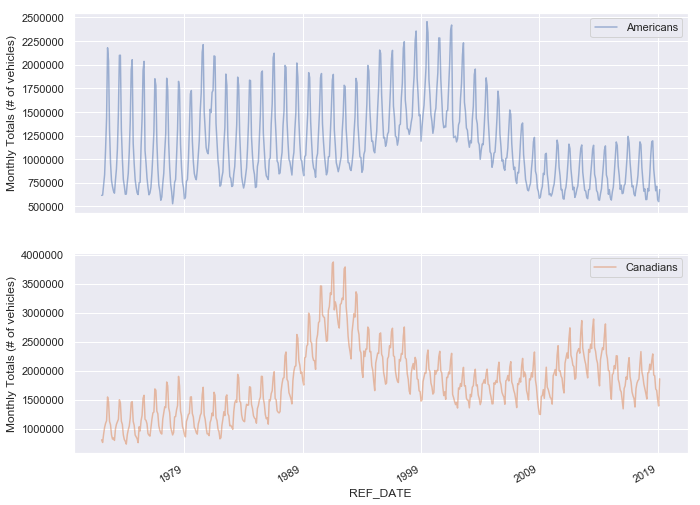

In [97]:
cols_plot = ['Americans', 'Canadians']
axes = can_crossings[cols_plot].plot(alpha = 0.5,
                                     #marker='-',
                                 #linestyle='None', 
                                 figsize=(11,9), 
                                 subplots=True)
for ax in axes:
    ax.set_ylabel('Monthly Totals (# of vehicles)')

*For both the Americans and Canadians there appears to be a yearly seaonality*

**Seasonality**

We can group the data by month and see the variation over the entire record.

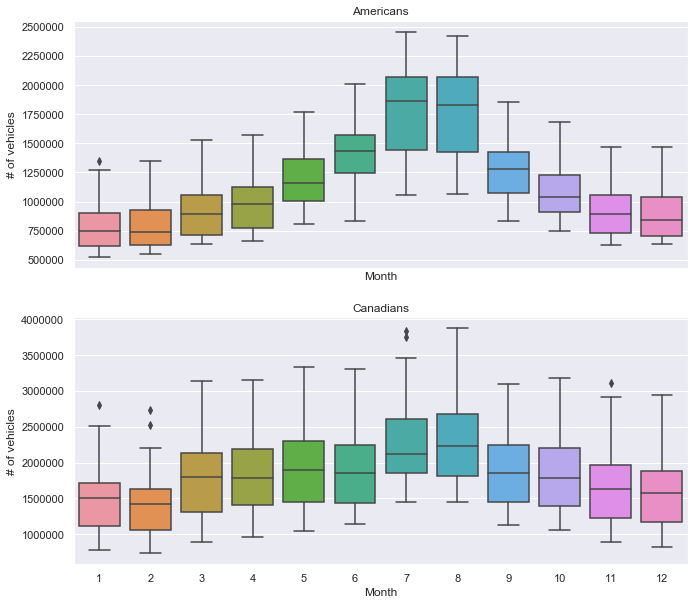

In [102]:
# Group date by month, to visualize yearly seasonality

# create 3 subplots in 1 column, of set size and share x-axis
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)

# Create a boxplot for each of ['Consumption', 'Solar','Wind']
for name, ax in zip(['Americans','Canadians'], axes):
    sns.boxplot(data=can_crossings, x='Month', y=name, ax=ax)
    ax.set_ylabel('# of vehicles')
    ax.set_title(name)
    
# Remove the auto x-axis label form all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

*The 'Americans' show a gradually increasing trend in visits peaking in July and August. This pattern is well represented across the entire record. The 'Canadians' have a low season between November and February, followed by a step increase in visits between March and June as well as September and October. Like the 'Americans' the peak in visits takes pace in July and August.*

## Trends

We can using a yearly rolling window to smooth out the montly seasonality so that we can see other trends in the data.

In [104]:
# min_periods argument accounts for missing data
can_crossings_365d = can_crossings[['Americans','Canadians']].rolling(window=12, 
                                             center=True,
                                            min_periods=10).mean()

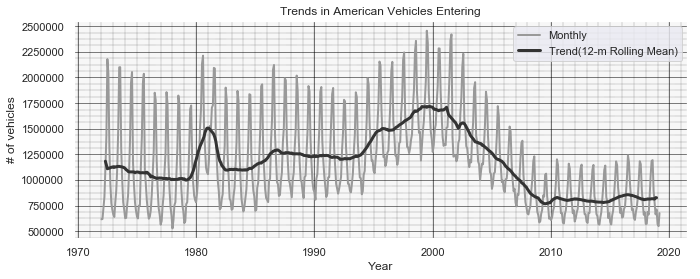

In [145]:
#Plot monthly and 365-day rolling mean time series
fig, ax = plt.subplots()

ax.plot(can_crossings['Americans'],
       color='0.6',
       linewidth=2,
       label='Monthly')

ax.plot(can_crossings_365d['Americans'],
       color='0.2',
       linewidth=3,
       label='Trend(12-m Rolling Mean)')

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Set major x-ticks to decadal intergal and minor x-ticks to yearly intergal
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(mdates.YearLocator())

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')

# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.4', color='black')

# Add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('# of vehicles')
ax.set_title('Trends in American Vehicles Entering')

# Modify background colour
ax.set_facecolor('#f7f7f7');

*There was an episode of increased crossings centered on 1981. An increasing trend took place from 1994 to 2001, followed by a decreasing trend until 2009 when visits leveled off at numbers lower than previously.*

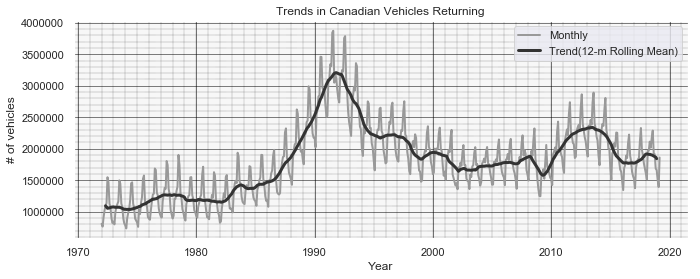

In [144]:
#Plot monthly and 365-day rolling mean time series
fig, ax = plt.subplots()

ax.plot(can_crossings['Canadians'],
       color='0.6',
       linewidth=2,
       label='Monthly')

ax.plot(can_crossings_365d['Canadians'],
       color='0.2',
       linewidth=3,
       label='Trend(12-m Rolling Mean)')

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Set major x-ticks to decadal intergal and minor x-ticks to yearly intergal
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(mdates.YearLocator())

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')

# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.4', color='black')

# Add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('# of vehicles')
ax.set_title('Trends in Canadian Vehicles Returning')

# Modify background colour
ax.set_facecolor('#f7f7f7')

*In the 70s there was a similar number of Canadian crossings as Americans. Starting in 1982 there was an increasing trend that reached its height in 1992. This was followed by a decreasing trend that ended around 2002. The leveling off was at a higher number of vehicles than seen previously. Another increased episode occurred from 2009 to 2015 centered on 2013.*